# Titanic - Machine Learning from Disaster

This project is to attempt to predict who lived and who died based on their other data, such as: gender, class, age, etc.	
The only columns that might need some explanation are mentioned below.


| Variable | Definition | Key |
| --- | --- | --- |
| survival | Survival |	0 = No, 1 = Yes |
| pclass | Ticket class | 1 = 1st, 2 = 2nd, 3 = 3rd |
| sex | Sex |  |
| Age | Age in years | |
| sibsp | # of siblings / spouses aboard the Titanic | |
| parch | # of parents / children aboard the Titanic | |
| ticket | 	Ticket number	| |
| fare | Passenger fare	| |
| cabin | Cabin number | |
| embarked | Port of Embarkation | C = Cherbourg, Q = Queenstown, S = Southampton | 
	
		

In [54]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [55]:
train = pd.read_csv('train.csv')

In [56]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [57]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 66.2+ KB


In [58]:
train[['Age', 'SibSp', 'Parch', 'Fare']].describe()

,Age,SibSp,Parch,Fare
count,714.000000,891.000000,891.000000,891.000000
mean,29.699118,0.523008,0.381594,32.204208
std,14.526497,1.102743,0.806057,49.693429
min,0.420000,0.000000,0.000000,0.000000
25%,20.125000,0.000000,0.000000,7.910400
50%,28.000000,0.000000,0.000000,14.454200
75%,38.000000,1.000000,0.000000,31.000000
max,80.000000,8.000000,6.000000,512.329200


## Data Cleaning

Looks like we'll need to clean some of this up, I'll do the following steps to clean it up:
1. Remove the cabin column, there's only 204 non-null values
2. Replace NaN age values with the mean age.
3. Remove the few rows that have null Embarked
4. Replace age with buckets of ages
5. Change the Survival to Yes or No, we'll change it back to 0s and 1s for the ML section

In [59]:
def clean_data(df):
    df.drop(['Cabin'], axis=1, inplace=True)
    df['Age'].fillna(df['Age'].mean(), inplace=True)
    df.dropna(inplace=True)
    
    bins = [0, 18, 30, 50, 120]
    labels = ['0-17', '18-29', '30-49', '50+']

    df['Age_bucket'] = pd.cut(df['Age'], bins, labels=labels)
    df.drop(['Ticket', 'SibSp', 'Parch', 'PassengerId', 'Name', 'Fare'], axis=1, inplace=True)
    
    return df

In [60]:
train = clean_data(train)

train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 0 to 890
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   Survived    889 non-null    int64   
 1   Pclass      889 non-null    int64   
 2   Sex         889 non-null    object  
 3   Age         889 non-null    float64 
 4   Embarked    889 non-null    object  
 5   Age_bucket  889 non-null    category
dtypes: category(1), float64(1), int64(2), object(2)
memory usage: 35.7+ KB


In [61]:
train['Survived'] = train['Survived'].map({1: 'Yes', 0: 'No'})

## Data Exploration

It's time to dig into the data to determine any insights or correlations before starting the Machine Learning section of the project.

<AxesSubplot:title={'center':'Survival by Gender'}, xlabel='Sex'>

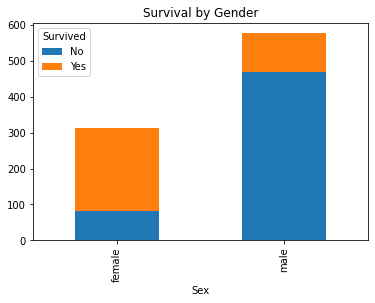

In [62]:
pd.crosstab(train['Sex'], train['Survived']).plot.bar(title = 'Survival by Gender', stacked=True)

### Survival by Sex

There were more males on board the titanic but it looks like more females ended up surviving. This lines up with historical recounting of the Titanic tales of women and children being allowed to get on the lifeboats first.

<AxesSubplot:title={'center':'Survival by Class'}, xlabel='Pclass'>

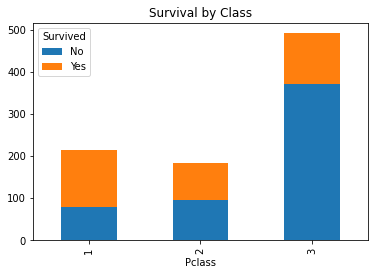

In [63]:
pd.crosstab(train['Pclass'], train['Survived']).plot.bar(title = 'Survival by Class', stacked=True)

### Survival by Class

Seems there was a higher chance of survival if the passenger happened to be a part of the 1st class. This isn't a surprise though this is just a quick glance and not actual hypothesis testing yet.

<AxesSubplot:title={'center':'Survival by Embarked'}, xlabel='Embarked'>

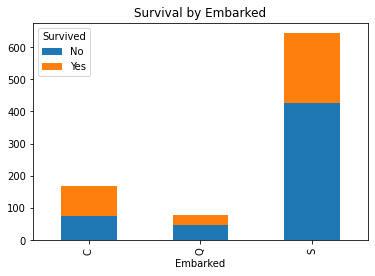

In [64]:
pd.crosstab(train['Embarked'], train['Survived']).plot.bar(title = 'Survival by Embarked', stacked=True)

### Survival by Port of Embarkation

Looks like there was a higher survival percentage from the people that embarked from Southampton. I think I'll need to label encode this so I can look at the correlation matrix and see if this and some other feature are correlated, possibly the Fare feature. It's possible that the more wealthy departed from this Southampton area while more of the less fortunate passengers embared from Cherbourg.

<AxesSubplot:title={'center':'Survival by Age'}, xlabel='Age_bucket'>

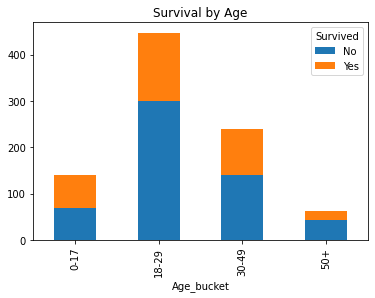

In [65]:
pd.crosstab(train['Age_bucket'], train['Survived']).plot.bar(title = 'Survival by Age', stacked=True)

### Survival by Age
There does seem to be a higher chance for passenger survival if the age was below 17, still looks to be only approximately 50% chance though which is surprising.

In [66]:
pd.crosstab(train['SibSp'], train['Survived']).plot.bar(title = 'Survival by Siblings\Spouse Count', stacked=True)

KeyError: 'SibSp'

In [67]:
train

,Survived,Pclass,Sex,Age,Embarked,Age_bucket
0,No,3,male,22.000000,S,18-29
1,Yes,1,female,38.000000,C,30-49
2,Yes,3,female,26.000000,S,18-29
3,Yes,1,female,35.000000,S,30-49
4,No,3,male,35.000000,S,30-49
...,...,...,...,...,...,...
886,No,2,male,27.000000,S,18-29
887,Yes,1,female,19.000000,S,18-29
888,No,3,female,29.699118,S,18-29
889,Yes,1,male,26.000000,C,18-29


In [ ]:
pd.crosstab(train['Parch'], train['Survived']).plot.bar(title = 'Survival by Parent\Children Count', stacked=True)

### Survival by Parent\Children and Siblings\Spouse
Seems like there might be a trend that shows a lower chance of survival if the person is on the ship alone but I'll combine these two for later analysis to see if that's true.

In [ ]:
# Compute the correlation matrix
# Conver gender to number real quick to look at in correlation matrix
train_corr = train
train_corr['Sex'] = train['Sex'].map({'male': 1, 'female': 0})

corr = train.drop('PassengerId', axis=1).corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

### Correlation Analysis

There's some interesting correlation in the matrix above which leads me to believe that I need to combine some columns or drop some altogether so that the ML model isn't manipulated too heavily one way because of 2 different features that are closely related.

- Pclass and Fare seem to be strongly negatively correlated which would make sense, the higher the priced ticket, the more likely it belonged to a Pclass of 1 or 1st class or Upper class socio-economic person. I might look at dropping Fare or thinking of a way to combine them.
- SibSp and Parch were somewhat positively correlated or the count of siblings and spouses were somewhat possitively correlated with the count of parents and children on board. These 2 fields will probably be combined for ML.
- Looking at just the Survived correlation, it seems likely that your socio-economic status had a relatively large impact on whether you survived or not. 
- Gender seems to be strongly negatively correlated with survival as well. Females were encoded as a 0 and survival is a 1 and since we can see there definitely seems to be a much higher chance of survival if the passenger was a female then the correlation makes sense.

## Hypothesis Testing for Individual Features
We'll take a look at each feature and do a quick and simple hypothesis test on them and try and match that up later in the more complex section of Machine Learning where things tend to enter a black box.

In [ ]:
import scipy.stats as stats
import researchpy as rp

In [ ]:
train['Survived'] = train['Survived'].map({'Yes':1 , 'No': 0})

In [ ]:
p_val = stats.ttest_ind(train[train['Sex'] == 0]['Survived'], train[train['Sex'] == 1]['Survived'], equal_var=False)

print(p_val)

In [ ]:
rp.ttest(group1 = train['Survived'][train['Sex'] == 1], group1_name='Male',
         group2 = train['Survived'][train['Sex'] == 0], group2_name='Female')

In [ ]:
p_val

### Gender Hypothesis Testing

I'm going to approach all these feature hypothesis tests as if I think there won't be a difference even if the graphs above show that there might be a difference.

The incredibly low p value of 1.2967913799919294e-60 shown above indicates there's a very tiny chance that more women survived than men due to random chance. So, we're rejecting the Null Hypothesis that says that male and female died at the same rate on the titanic.

In [ ]:
rp.summary_cont(train['Survived'].groupby(train['Pclass']))['Mean'].plot.bar(
    yerr=rp.summary_cont(train['Survived'].groupby(train['Pclass']))['SE'])

In [ ]:
rp.summary_cont(train['Survived'].groupby(train['Pclass']))

In [ ]:
stats.f_oneway(train['Survived'][train['Pclass'] == 1],
               train['Survived'][train['Pclass'] == 2],
               train['Survived'][train['Pclass'] == 3])

### Class Hypothesis Testing
Here, we needed to use ANOVA since there are more than 2 variables in the feature. We could do the simple t-test for gender but couldn't do that here. It does look like there is a statistically significant result when looking at survival and the passenger's class on the ticket. We can see this with the extremely low p value as well as in the bar graph where none of the error bars overlap with eachother. 

In [ ]:
rp.summary_cont(train['Survived'].groupby(train['Embarked']))['Mean'].plot.bar(
    yerr=rp.summary_cont(train['Survived'].groupby(train['Embarked']))['SE'])

In [ ]:
rp.summary_cont(train['Survived'].groupby(train['Embarked']))

In [ ]:
stats.f_oneway(train['Survived'][train['Embarked'] == 'C'],
               train['Survived'][train['Embarked'] == 'Q'],
               train['Survived'][train['Embarked'] == 'S'])

### Embarked Hypothesis Testing
Looks like the p value is still quite a bit lower than the 0.05 or 5% we're looking at so it looks like there's a statistically significant difference in survival rates depending on location embarked. 

After looking at the bar graph though, it looks like Queenstown shows a mean survival rate of higher than Southampton but it's not statistically significant. It does look like Cherbourg did have a statistically significant higher rate of survival than the other two.

In [ ]:
rp.summary_cont(train['Survived'].groupby(train['Age_bucket']))['Mean'].plot.bar(
    yerr=rp.summary_cont(train['Survived'].groupby(train['Age_bucket']))['SE'])

In [ ]:
rp.summary_cont(train['Survived'].groupby(train['Age_bucket']))

In [ ]:
stats.f_oneway(train['Survived'][train['Age_bucket'] == '0-17'],
               train['Survived'][train['Age_bucket'] == '18-29'],
               train['Survived'][train['Age_bucket'] == '30-49'],
               train['Survived'][train['Age_bucket'] == '50+'])

### Age Bucket Hypothesis Testing
Looks like our p-value is finally getting smaller with this test. It is still smaller than 0.05 but not by a huge margin, so it's more likely our results could be due to luck but it still is a statisically significant result since our alpha is 0.05. 

If you look at the bar graph again though I do think it's fair to say that the age group of 0-17 had a much higher chance of survival when looking at their age, though this could be due to other factors and doesn't indicate causality.

In [ ]:
train['SibSp_Parch'] = train['SibSp'] + train['Parch']

In [ ]:
rp.summary_cont(train['Survived'].groupby([train['SibSp_Parch'] == 0]))['Mean'].plot.bar(
    yerr=rp.summary_cont(train['Survived'].groupby([train['SibSp_Parch'] == 0]))['SE'])

In [ ]:
stats.f_oneway(train['Survived'][train['SibSp_Parch'] == 0],
               train['Survived'][train['SibSp_Parch'] > 0])


### Siblings, Parents, Spouses, Children Hypothesis Testing
I went ahead and combined these two columns into SibSp_Parch for this analysis since they're pretty closely correlated and we'll probably do this for the ML section anyways. I then just broke it down into 2 categories of basically having someone on the ship with this label or having no one the ship with this label. There were a surpising amount of people that went on the ship with none of these (no parents, children, spouses or siblings). In fact, there were more people without someone that with someone. 

After looking at the graph and the error bars as well as the p-value in the ANOVA test, it appears there is a statistically significant correlation between having someone on the ship and having a slighly higher chance of surivival. 

## Feature Selection
This is normally important for very large datasets with a lot more columns than the current one, I want to go through the exercise though still because it's an important skill to have when looking at ML programs.

A quick description of what it is and why it's done:
- Feature selection is the process of reducing the number of input variables when developing a predictive model. It is desirable to reduce the number of input variables to both reduce the computational cost of modeling and, in some cases, to improve the performance of the model.

In [ ]:
train.head()

### Encoding

Need to one-hot encode the embarked column so we can get it into digits for Machine Learning. We can't label encode because that will create an order to the column when there is no order to Embarked. 

Age_bucket we will just label encode since there is an actual order to ages.

In [ ]:
from sklearn import preprocessing

def encoding(df): 
    df = df.join(pd.get_dummies(df['Embarked'],prefix='Embarked'))
    df.drop('Embarked', axis=1, inplace=True)
    df.drop('Age', axis=1, inplace=True)
    le = preprocessing.LabelEncoder()
    df['Age_bucket'] = le.fit_transform(df['Age_bucket'])
    return df


In [ ]:
train = encoding(train)

In [ ]:
train.head()

In [ ]:
from sklearn.feature_selection import SelectKBest, f_classif

In [ ]:
X = train.drop(['Survived'], axis=1)
y = train['Survived']

In [ ]:
normalized_df=(X-X.mean())/X.std()

In [ ]:
skb = SelectKBest(f_classif, k=7)
skb.fit_transform(X, y)

skb_2 = SelectKBest(f_classif, k=4)
skb_2.fit_transform(X, y)

In [ ]:
names = X.columns.values[skb.get_support()]
p_values = skb.pvalues_[skb.get_support()]
scores = skb.scores_[skb.get_support()]

names_scores = list(zip(names, scores, p_values))

ns_df = pd.DataFrame(data = names_scores, columns= ['Feat_names','scores', 'p_values'])
ns_df_sorted = ns_df.sort_values(['p_values','Feat_names'], ascending = [True, False])
ns_df_sorted

In [ ]:
names = X.columns.values[skb_2.get_support()]
p_values = skb_2.pvalues_[skb_2.get_support()]
scores = skb_2.scores_[skb_2.get_support()]

names_scores = list(zip(names, scores, p_values))

ns_df = pd.DataFrame(data = names_scores, columns= ['Feat_names','scores', 'p_values'])
ns_df_sorted = ns_df.sort_values(['p_values','Feat_names'], ascending = [True, False])
ns_df_sorted

### Select K Best Analysis
So it looks like Age_bucket, SibSp_Parch and Embarked_Q aren't that helpful, so just out of curiousity I'm going to have 2 different dataframes, one with all the columns and another with only the features that were below a 0.05 p value according to the K-Best model. The models are skb and skb_2 respectively.

In [ ]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(X, y)



In [ ]:
test = pd.read_csv('test.csv')
test = clean_data(test)
test